<a href="https://colab.research.google.com/github/Deare-stack/GenAI/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Deare
### 2024/10/6
### Assignment 3

### Install essential Python libraries for machine learning and data processing,
##and download the SVHN dataset for model training and testing.
!pip install tensorflow numpy scipy pillow matplotlib
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-06 22:21:04--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  17.6MB/s    in 10s     

2024-10-06 22:21:14 (17.3 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-06 22:21:14--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  16.3MB/s    in 4.8s    

2024-10-06 22:21:19 (12.7 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [ ]:
from scipy.io import loadmat  # Import the function 'loadmat' from the 'scipy.io' module to enable loading MATLAB files.
import numpy as np  # Import the 'numpy' library, often used for numerical operations, under the alias 'np'.

# Load data
train_data = loadmat('train_32x32.mat')  # Load the training data from the MATLAB file 'train_32x32.mat'.
test_data = loadmat('test_32x32.mat')  # Load the test data from the MATLAB file 'test_32x32.mat'.

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0  # Rearrange the axes of the training images for processing, convert to float32, and normalize the pixel values.
y_train = train_data['y'].flatten()  # Flatten the training labels array to a single dimension.
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0  # Rearrange the axes of the testing images for processing, convert to float32, and normalize the pixel values.
y_test = test_data['y'].flatten()  # Flatten the test labels array to a single dimension.

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')  # Print the shape of the processed training data.
print(f'Test data shape: {x_test.shape}')  # Print the shape of the processed test data.

Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


In [27]:
##Step 2: Build a Variational Autoencoder (VAE)

## In this step the idea of improving loss is crucial it directly impact the traning
## To improe loss function first I added dropout after the convolutional layers in both the encoder and decoder of the VAE,
## Also I add the learning rate,I've thought about changing optimization but I didn't because Adam is the optimization can update weights at each step
## my idea is update the learning rate higher to explore if it allows for more substantial updates to the weights.
## Add dropout to pervent overffting which means it should generalize better on new, unseen data.
from tensorflow.keras import layers, models, losses# Import necessary libraries and modules from TensorFlow and Keras.
import tensorflow as tf

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0] # Get the batch size.
    dim = tf.shape(z_mean)[1]# Get the dimensionality of the latent space.
    epsilon = tf.random.normal(shape=(batch, dim))# Generate random noise (epsilon)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon# Return z by adjusting mean with the noise scaled by the variance
# Define the function to build a Variational Autoencoder (VAE).
def build_vae(latent_dim):
    # # Encoder Part:
    inputs = layers.Input(shape=(32, 32, 3))# Define input layer for images with shape 32x32x3
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)# First convolutional layer with 32 filters, kernel size of 3, and down-sampling.
    x = layers.Dropout(0.3)(x) # # Dropout to prevent overfitting by randomly setting input units to 0 at a rate of 0.3 during training
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)# Second convolutional layer increasing the depth to 64.
    x = layers.Dropout(0.3)(x) # # Another dropout for additional regularization.
    x = layers.Flatten()(x)# Flatten the 3D output to 1D before passing to the dense layers fully connected layes.
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)# Dense layer to output the mean of the latent space distribution.
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)# Dense layer to output the logarithm of the variance of the latent space distribution.
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) # Lambda layer to sample from the distribution using the `sampling` function.

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,)) # Define the input layer for the decoder using the latent dimension.
    x = layers.Dense(8 * 8 * 64, activation='relu')(latent_inputs)# Dense layer to expand the latent vector into a larger vector suitable for reshaping into a feature map.
    x = layers.Reshape((8, 8, 64))(x)# # Reshape the output of the dense layer into a 3D feature map, preparing it for convolutional layers.
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)## Transposed convolution (or deconvolution) layer that upsamples the feature map to a larger spatial dimension, using 64 filters of size 3x3.
    x = layers.Dropout(0.3)(x) # Apply dropout to the first transposed convolution layer to prevent overfitting by randomly setting a fraction (30%) of input units to 0 at each update during training time.
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)# Second transposed convolution layer that further upsamples the feature map, reducing the number of filters to 32 for generating finer details.
    x = layers.Dropout(0.3)(x) # Apply dropout to the second transposed convolution layer for additional regularization.
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)# Final transposed convolution layer that maps the feature map back to the original image dimensions with 3 channels (assuming RGB images), using a sigmoid activation to ensure the output pixel values are between 0 and 1.

    # Instantiate the encoder, decoder, and VAE models
    encoder = models.Model(inputs, [z_mean, z_log_var, z], name="encoder") # The encoder model.
    decoder = models.Model(latent_inputs, outputs, name="decoder")# The decoder model.
    vae_outputs = decoder(encoder(inputs)[2])# Pass the output of the encoder (sampled z values) to the decoder.
    vae = models.Model(inputs, vae_outputs, name="vae")# Complete VAE model.

    # Add VAE loss
    reconstruction_loss = losses.binary_crossentropy(inputs, vae_outputs)# Compute the binary crossentropy loss between input and VAE output.
    reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=(1,2)) # Calculate sum of losses per image,sum over features for each sample.
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)# Calculate the KL loss for each sample.
    vae.add_loss(tf.reduce_mean(reconstruction_loss + kl_loss))# Add the average VAE loss to the model.
    return vae# Return the complete model.

In [28]:
##Step 3: Train the VAE with Various Latent Dimensions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Import necessary callback functions
import tensorflow as tf  # Import TensorFlow

latent_dims = [2, 5, 10]  # Define different sizes for the latent space to explore their impacts on the model's performance
for dim in latent_dims:  # Iterate over each specified latent dimension
    print(f"Training VAE with latent dimension: {dim}")  # Print the current latent dimension being used for training
    vae = build_vae(latent_dim=dim)  # Build a VAE model with the current latent dimension
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Compile the model using the Adam optimizer
                loss=tf.keras.losses.MeanSquaredError())  # Use Mean Squared Error as the loss function

    # Setup callbacks for saving the best model and early stopping
    checkpoint_callback = ModelCheckpoint(
        f'vae_model_dim_{dim}.h5',  # Specify the file path where the best model will be saved
        save_best_only=True,  # Only save the model if its 'val_loss' has improved
        monitor='val_loss',  # Monitor the validation loss to determine improvement
        mode='min',  # The goal is to minimize the validation loss
        verbose=1  # Print messages when the model is being saved
    )
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss to decide when to stop training
        patience=10,  # Stop training if no improvement in validation loss after 10 epochs
        verbose=1  # Print messages when training is stopped prematurely
    )

    # Train the model using the defined callbacks
    vae.fit(
        x_train, x_train,  # Training data where inputs are the same as the targets (unsupervised learning)
        epochs=50,  # Set the maximum number of epochs for training
        batch_size=128,  # The number of samples per batch of computation
        validation_data=(x_test, x_test),  # Validation data used to evaluate the loss and any model metrics at the end of each epoch
        callbacks=[checkpoint_callback, early_stopping_callback]  # List of callbacks to apply during training
    )

Training VAE with latent dimension: 2
Epoch 1/50
572/573 [============================>.] - ETA: 0s - loss: 693.3131
Epoch 1: val_loss improved from inf to 675.99072, saving model to vae_model_dim_2.h5


573/573 [==============================] - 28s 46ms/step - loss: 693.3060 - val_loss: 675.9907
Epoch 2/50
573/573 [==============================] - ETA: 0s - loss: 684.1779
Epoch 2: val_loss improved from 675.99072 to 672.56628, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 684.1779 - val_loss: 672.5663
Epoch 3/50
573/573 [==============================] - ETA: 0s - loss: 681.3530
Epoch 3: val_loss improved from 672.56628 to 668.81287, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 681.3530 - val_loss: 668.8129
Epoch 4/50
572/573 [============================>.] - ETA: 0s - loss: 679.4034
Epoch 4: val_loss improved from 668.81287 to 666.63885, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 679.4076 - val_loss: 666.6389
Epoch 5/50
573/573 [==============================] - ETA: 0s - loss: 678.2284
Epoch 5: val_loss improved from 666.63885 to 665.13214, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 678.2284 - val_loss: 665.1321
Epoch 6/50
572/573 [============================>.] - ETA: 0s - loss: 677.2510
Epoch 6: val_loss improved from 665.13214 to 663.35803, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 677.2570 - val_loss: 663.3580
Epoch 7/50
572/573 [============================>.] - ETA: 0s - loss: 676.4879
Epoch 7: val_loss improved from 663.35803 to 662.68579, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 676.4839 - val_loss: 662.6858
Epoch 8/50
573/573 [==============================] - ETA: 0s - loss: 676.1439
Epoch 8: val_loss improved from 662.68579 to 661.40503, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 676.1439 - val_loss: 661.4050
Epoch 9/50
572/573 [============================>.] - ETA: 0s - loss: 675.6674
Epoch 9: val_loss improved from 661.40503 to 661.07861, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 675.6640 - val_loss: 661.0786
Epoch 10/50
572/573 [============================>.] - ETA: 0s - loss: 674.7843
Epoch 10: val_loss improved from 661.07861 to 654.57513, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 674.7814 - val_loss: 654.5751
Epoch 11/50
573/573 [==============================] - ETA: 0s - loss: 665.7995
Epoch 11: val_loss improved from 654.57513 to 647.54669, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 665.7995 - val_loss: 647.5467
Epoch 12/50
572/573 [============================>.] - ETA: 0s - loss: 663.1548
Epoch 12: val_loss improved from 647.54669 to 645.47119, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 663.1505 - val_loss: 645.4712
Epoch 13/50
573/573 [==============================] - ETA: 0s - loss: 661.7901
Epoch 13: val_loss improved from 645.47119 to 643.87152, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 661.7901 - val_loss: 643.8715
Epoch 14/50
573/573 [==============================] - ETA: 0s - loss: 660.7531
Epoch 14: val_loss improved from 643.87152 to 642.53394, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 660.7531 - val_loss: 642.5339
Epoch 15/50
573/573 [==============================] - ETA: 0s - loss: 660.0121
Epoch 15: val_loss improved from 642.53394 to 641.60437, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 660.0121 - val_loss: 641.6044
Epoch 16/50
572/573 [============================>.] - ETA: 0s - loss: 659.4037
Epoch 16: val_loss improved from 641.60437 to 640.78497, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 659.4059 - val_loss: 640.7850
Epoch 17/50
573/573 [==============================] - ETA: 0s - loss: 658.9091
Epoch 17: val_loss improved from 640.78497 to 640.06714, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 658.9091 - val_loss: 640.0671
Epoch 18/50
572/573 [============================>.] - ETA: 0s - loss: 658.4877
Epoch 18: val_loss improved from 640.06714 to 639.47083, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 658.4854 - val_loss: 639.4708
Epoch 19/50
572/573 [============================>.] - ETA: 0s - loss: 658.1190
Epoch 19: val_loss improved from 639.47083 to 638.90076, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 658.1166 - val_loss: 638.9008
Epoch 20/50
573/573 [==============================] - ETA: 0s - loss: 657.8197
Epoch 20: val_loss improved from 638.90076 to 638.55084, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 657.8197 - val_loss: 638.5508
Epoch 21/50
572/573 [============================>.] - ETA: 0s - loss: 657.5528
Epoch 21: val_loss improved from 638.55084 to 637.94348, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 657.5588 - val_loss: 637.9435
Epoch 22/50
573/573 [==============================] - ETA: 0s - loss: 657.3296
Epoch 22: val_loss improved from 637.94348 to 637.83752, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 657.3296 - val_loss: 637.8375
Epoch 23/50
573/573 [==============================] - ETA: 0s - loss: 657.1413
Epoch 23: val_loss improved from 637.83752 to 637.30957, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 657.1413 - val_loss: 637.3096
Epoch 24/50
572/573 [============================>.] - ETA: 0s - loss: 656.9764
Epoch 24: val_loss improved from 637.30957 to 637.06799, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 656.9681 - val_loss: 637.0680
Epoch 25/50
572/573 [============================>.] - ETA: 0s - loss: 656.8388
Epoch 25: val_loss improved from 637.06799 to 636.76459, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 656.8369 - val_loss: 636.7646
Epoch 26/50
572/573 [============================>.] - ETA: 0s - loss: 656.7242
Epoch 26: val_loss improved from 636.76459 to 636.54797, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 656.7269 - val_loss: 636.5480
Epoch 27/50
572/573 [============================>.] - ETA: 0s - loss: 656.5933
Epoch 27: val_loss improved from 636.54797 to 636.27063, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 656.5960 - val_loss: 636.2706
Epoch 28/50
572/573 [============================>.] - ETA: 0s - loss: 656.5216
Epoch 28: val_loss improved from 636.27063 to 636.24658, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 656.5229 - val_loss: 636.2466
Epoch 29/50
573/573 [==============================] - ETA: 0s - loss: 656.4431
Epoch 29: val_loss improved from 636.24658 to 635.91785, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 656.4431 - val_loss: 635.9178
Epoch 30/50
573/573 [==============================] - ETA: 0s - loss: 656.3812
Epoch 30: val_loss did not improve from 635.91785
573/573 [==============================] - 25s 43ms/step - loss: 656.3812 - val_loss: 635.9234
Epoch 31/50
572/573 [============================>.] - ETA: 0s - loss: 656.3239
Epoch 31: val_loss improved from 635.91785 to 635.68622, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 656.3313 - val_loss: 635.6862
Epoch 32/50
572/573 [============================>.] - ETA: 0s - loss: 656.2612
Epoch 32: val_loss improved from 635.68622 to 635.54584, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 656.2614 - val_loss: 635.5458
Epoch 33/50
573/573 [==============================] - ETA: 0s - loss: 656.2220
Epoch 33: val_loss improved from 635.54584 to 635.47974, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 656.2220 - val_loss: 635.4797
Epoch 34/50
572/573 [============================>.] - ETA: 0s - loss: 656.1667
Epoch 34: val_loss improved from 635.47974 to 635.46338, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 42ms/step - loss: 656.1774 - val_loss: 635.4634
Epoch 35/50
572/573 [============================>.] - ETA: 0s - loss: 656.1409
Epoch 35: val_loss improved from 635.46338 to 635.27313, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 656.1400 - val_loss: 635.2731
Epoch 36/50
573/573 [==============================] - ETA: 0s - loss: 656.0904
Epoch 36: val_loss improved from 635.27313 to 635.16541, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 656.0904 - val_loss: 635.1654
Epoch 37/50
572/573 [============================>.] - ETA: 0s - loss: 656.0844
Epoch 37: val_loss did not improve from 635.16541
573/573 [==============================] - 24s 43ms/step - loss: 656.0786 - val_loss: 635.2477
Epoch 38/50
573/573 [==============================] - ETA: 0s - loss: 656.0451
Epoch 38: val_loss improved from 635.16541 to 634.99475, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 656.0451 - val_loss: 634.9948
Epoch 39/50
572/573 [============================>.] - ETA: 0s - loss: 656.0247
Epoch 39: val_loss did not improve from 634.99475
573/573 [==============================] - 24s 43ms/step - loss: 656.0247 - val_loss: 635.0065
Epoch 40/50
573/573 [==============================] - ETA: 0s - loss: 656.0184
Epoch 40: val_loss improved from 634.99475 to 634.86243, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 656.0184 - val_loss: 634.8624
Epoch 41/50
572/573 [============================>.] - ETA: 0s - loss: 655.9976
Epoch 41: val_loss improved from 634.86243 to 634.83258, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 655.9983 - val_loss: 634.8326
Epoch 42/50
573/573 [==============================] - ETA: 0s - loss: 655.9811
Epoch 42: val_loss improved from 634.83258 to 634.75531, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 44ms/step - loss: 655.9811 - val_loss: 634.7553
Epoch 43/50
573/573 [==============================] - ETA: 0s - loss: 655.9508
Epoch 43: val_loss did not improve from 634.75531
573/573 [==============================] - 24s 43ms/step - loss: 655.9508 - val_loss: 634.8561
Epoch 44/50
573/573 [==============================] - ETA: 0s - loss: 655.9578
Epoch 44: val_loss improved from 634.75531 to 634.74231, saving model to vae_model_dim_2.h5


573/573 [==============================] - 25s 43ms/step - loss: 655.9578 - val_loss: 634.7423
Epoch 45/50
572/573 [============================>.] - ETA: 0s - loss: 655.9449
Epoch 45: val_loss did not improve from 634.74231
573/573 [==============================] - 25s 43ms/step - loss: 655.9456 - val_loss: 634.8101
Epoch 46/50
572/573 [============================>.] - ETA: 0s - loss: 655.9191
Epoch 46: val_loss did not improve from 634.74231
573/573 [==============================] - 24s 43ms/step - loss: 655.9193 - val_loss: 634.8472
Epoch 47/50
572/573 [============================>.] - ETA: 0s - loss: 655.9289
Epoch 47: val_loss did not improve from 634.74231
573/573 [==============================] - 25s 43ms/step - loss: 655.9224 - val_loss: 634.8024
Epoch 48/50
572/573 [============================>.] - ETA: 0s - loss: 655.9010
Epoch 48: val_loss improved from 634.74231 to 634.59406, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 655.9033 - val_loss: 634.5941
Epoch 49/50
573/573 [==============================] - ETA: 0s - loss: 655.8926
Epoch 49: val_loss improved from 634.59406 to 634.56042, saving model to vae_model_dim_2.h5


573/573 [==============================] - 24s 43ms/step - loss: 655.8926 - val_loss: 634.5604
Epoch 50/50
572/573 [============================>.] - ETA: 0s - loss: 655.9159
Epoch 50: val_loss did not improve from 634.56042
573/573 [==============================] - 24s 43ms/step - loss: 655.9121 - val_loss: 634.6871
Training VAE with latent dimension: 5
Epoch 1/50
572/573 [============================>.] - ETA: 0s - loss: 689.7377
Epoch 1: val_loss improved from inf to 666.92969, saving model to vae_model_dim_5.h5


573/573 [==============================] - 28s 46ms/step - loss: 689.7319 - val_loss: 666.9297
Epoch 2/50
572/573 [============================>.] - ETA: 0s - loss: 669.2368
Epoch 2: val_loss improved from 666.92969 to 642.70551, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 669.2314 - val_loss: 642.7055
Epoch 3/50
573/573 [==============================] - ETA: 0s - loss: 657.1761
Epoch 3: val_loss improved from 642.70551 to 631.91443, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 657.1761 - val_loss: 631.9144
Epoch 4/50
572/573 [============================>.] - ETA: 0s - loss: 652.9554
Epoch 4: val_loss improved from 631.91443 to 629.99280, saving model to vae_model_dim_5.h5


573/573 [==============================] - 24s 43ms/step - loss: 652.9543 - val_loss: 629.9928
Epoch 5/50
572/573 [============================>.] - ETA: 0s - loss: 651.6427
Epoch 5: val_loss improved from 629.99280 to 629.01154, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 651.6512 - val_loss: 629.0115
Epoch 6/50
572/573 [============================>.] - ETA: 0s - loss: 650.8557
Epoch 6: val_loss improved from 629.01154 to 628.49268, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 650.8525 - val_loss: 628.4927
Epoch 7/50
573/573 [==============================] - ETA: 0s - loss: 650.2342
Epoch 7: val_loss improved from 628.49268 to 628.17181, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 650.2342 - val_loss: 628.1718
Epoch 8/50
573/573 [==============================] - ETA: 0s - loss: 649.8616
Epoch 8: val_loss improved from 628.17181 to 627.89215, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 649.8616 - val_loss: 627.8922
Epoch 9/50
573/573 [==============================] - ETA: 0s - loss: 649.6502
Epoch 9: val_loss improved from 627.89215 to 627.75275, saving model to vae_model_dim_5.h5


573/573 [==============================] - 24s 42ms/step - loss: 649.6502 - val_loss: 627.7527
Epoch 10/50
573/573 [==============================] - ETA: 0s - loss: 649.5040
Epoch 10: val_loss did not improve from 627.75275
573/573 [==============================] - 25s 43ms/step - loss: 649.5040 - val_loss: 627.8203
Epoch 11/50
572/573 [============================>.] - ETA: 0s - loss: 649.4057
Epoch 11: val_loss improved from 627.75275 to 627.46674, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 649.4054 - val_loss: 627.4667
Epoch 12/50
573/573 [==============================] - ETA: 0s - loss: 649.3111
Epoch 12: val_loss did not improve from 627.46674
573/573 [==============================] - 24s 43ms/step - loss: 649.3111 - val_loss: 627.5024
Epoch 13/50
572/573 [============================>.] - ETA: 0s - loss: 649.2352
Epoch 13: val_loss did not improve from 627.46674
573/573 [==============================] - 24s 43ms/step - loss: 649.2358 - val_loss: 627.4947
Epoch 14/50
572/573 [============================>.] - ETA: 0s - loss: 649.1572
Epoch 14: val_loss improved from 627.46674 to 627.44916, saving model to vae_model_dim_5.h5


573/573 [==============================] - 24s 43ms/step - loss: 649.1672 - val_loss: 627.4492
Epoch 15/50
572/573 [============================>.] - ETA: 0s - loss: 649.1013
Epoch 15: val_loss improved from 627.44916 to 627.38635, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 649.1027 - val_loss: 627.3864
Epoch 16/50
572/573 [============================>.] - ETA: 0s - loss: 649.0659
Epoch 16: val_loss did not improve from 627.38635
573/573 [==============================] - 24s 43ms/step - loss: 649.0694 - val_loss: 627.4543
Epoch 17/50
573/573 [==============================] - ETA: 0s - loss: 649.0079
Epoch 17: val_loss improved from 627.38635 to 627.27875, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 649.0079 - val_loss: 627.2787
Epoch 18/50
573/573 [==============================] - ETA: 0s - loss: 648.9521
Epoch 18: val_loss improved from 627.27875 to 627.10901, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 648.9521 - val_loss: 627.1090
Epoch 19/50
572/573 [============================>.] - ETA: 0s - loss: 648.9299
Epoch 19: val_loss did not improve from 627.10901
573/573 [==============================] - 25s 43ms/step - loss: 648.9236 - val_loss: 627.3789
Epoch 20/50
573/573 [==============================] - ETA: 0s - loss: 648.8581
Epoch 20: val_loss did not improve from 627.10901
573/573 [==============================] - 24s 43ms/step - loss: 648.8581 - val_loss: 627.2296
Epoch 21/50
572/573 [============================>.] - ETA: 0s - loss: 648.8188
Epoch 21: val_loss improved from 627.10901 to 627.00366, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 648.8181 - val_loss: 627.0037
Epoch 22/50
572/573 [============================>.] - ETA: 0s - loss: 648.7454
Epoch 22: val_loss improved from 627.00366 to 626.93237, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 648.7457 - val_loss: 626.9324
Epoch 23/50
573/573 [==============================] - ETA: 0s - loss: 648.6968
Epoch 23: val_loss improved from 626.93237 to 626.90472, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 648.6968 - val_loss: 626.9047
Epoch 24/50
572/573 [============================>.] - ETA: 0s - loss: 648.6643
Epoch 24: val_loss improved from 626.90472 to 626.84045, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 44ms/step - loss: 648.6717 - val_loss: 626.8405
Epoch 25/50
572/573 [============================>.] - ETA: 0s - loss: 648.6426
Epoch 25: val_loss improved from 626.84045 to 626.76886, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 44ms/step - loss: 648.6349 - val_loss: 626.7689
Epoch 26/50
572/573 [============================>.] - ETA: 0s - loss: 648.6076
Epoch 26: val_loss improved from 626.76886 to 626.75031, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 648.6024 - val_loss: 626.7503
Epoch 27/50
573/573 [==============================] - ETA: 0s - loss: 648.5753
Epoch 27: val_loss improved from 626.75031 to 626.70691, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 44ms/step - loss: 648.5753 - val_loss: 626.7069
Epoch 28/50
573/573 [==============================] - ETA: 0s - loss: 648.5493
Epoch 28: val_loss improved from 626.70691 to 626.69330, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 43ms/step - loss: 648.5493 - val_loss: 626.6933
Epoch 29/50
572/573 [============================>.] - ETA: 0s - loss: 648.5455
Epoch 29: val_loss did not improve from 626.69330
573/573 [==============================] - 25s 43ms/step - loss: 648.5413 - val_loss: 626.7422
Epoch 30/50
572/573 [============================>.] - ETA: 0s - loss: 648.5006
Epoch 30: val_loss improved from 626.69330 to 626.65076, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 44ms/step - loss: 648.5013 - val_loss: 626.6508
Epoch 31/50
573/573 [==============================] - ETA: 0s - loss: 648.4965
Epoch 31: val_loss did not improve from 626.65076
573/573 [==============================] - 25s 44ms/step - loss: 648.4965 - val_loss: 626.7000
Epoch 32/50
572/573 [============================>.] - ETA: 0s - loss: 648.4794
Epoch 32: val_loss improved from 626.65076 to 626.55042, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 44ms/step - loss: 648.4719 - val_loss: 626.5504
Epoch 33/50
572/573 [============================>.] - ETA: 0s - loss: 648.4684
Epoch 33: val_loss improved from 626.55042 to 626.53595, saving model to vae_model_dim_5.h5


573/573 [==============================] - 25s 44ms/step - loss: 648.4710 - val_loss: 626.5359
Epoch 34/50
573/573 [==============================] - ETA: 0s - loss: 648.4387
Epoch 34: val_loss did not improve from 626.53595
573/573 [==============================] - 25s 43ms/step - loss: 648.4387 - val_loss: 626.5710
Epoch 35/50
572/573 [============================>.] - ETA: 0s - loss: 648.4276
Epoch 35: val_loss improved from 626.53595 to 626.41852, saving model to vae_model_dim_5.h5


573/573 [==============================] - 24s 43ms/step - loss: 648.4230 - val_loss: 626.4185
Epoch 36/50
572/573 [============================>.] - ETA: 0s - loss: 648.4188
Epoch 36: val_loss did not improve from 626.41852
573/573 [==============================] - 24s 43ms/step - loss: 648.4042 - val_loss: 626.5620
Epoch 37/50
572/573 [============================>.] - ETA: 0s - loss: 648.3943
Epoch 37: val_loss did not improve from 626.41852
573/573 [==============================] - 24s 43ms/step - loss: 648.3976 - val_loss: 626.5955
Epoch 38/50
573/573 [==============================] - ETA: 0s - loss: 648.3889
Epoch 38: val_loss did not improve from 626.41852
573/573 [==============================] - 24s 42ms/step - loss: 648.3889 - val_loss: 626.5764
Epoch 39/50
573/573 [==============================] - ETA: 0s - loss: 648.3846
Epoch 39: val_loss did not improve from 626.41852
573/573 [==============================] - 24s 42ms/step - loss: 648.3846 - val_loss: 626.4764
Epoch

573/573 [==============================] - 24s 42ms/step - loss: 648.3389 - val_loss: 626.3787
Epoch 44/50
573/573 [==============================] - ETA: 0s - loss: 648.3410
Epoch 44: val_loss did not improve from 626.37866
573/573 [==============================] - 24s 42ms/step - loss: 648.3410 - val_loss: 626.6679
Epoch 45/50
573/573 [==============================] - ETA: 0s - loss: 648.3273
Epoch 45: val_loss improved from 626.37866 to 626.37689, saving model to vae_model_dim_5.h5


573/573 [==============================] - 24s 42ms/step - loss: 648.3273 - val_loss: 626.3769
Epoch 46/50
572/573 [============================>.] - ETA: 0s - loss: 648.3031
Epoch 46: val_loss did not improve from 626.37689
573/573 [==============================] - 24s 43ms/step - loss: 648.3113 - val_loss: 626.3809
Epoch 47/50
572/573 [============================>.] - ETA: 0s - loss: 648.3117
Epoch 47: val_loss did not improve from 626.37689
573/573 [==============================] - 24s 42ms/step - loss: 648.3152 - val_loss: 626.5326
Epoch 48/50
573/573 [==============================] - ETA: 0s - loss: 648.3093
Epoch 48: val_loss improved from 626.37689 to 626.36749, saving model to vae_model_dim_5.h5


573/573 [==============================] - 24s 42ms/step - loss: 648.3093 - val_loss: 626.3675
Epoch 49/50
573/573 [==============================] - ETA: 0s - loss: 648.2943
Epoch 49: val_loss did not improve from 626.36749
573/573 [==============================] - 24s 42ms/step - loss: 648.2943 - val_loss: 626.3702
Epoch 50/50
572/573 [============================>.] - ETA: 0s - loss: 648.2885
Epoch 50: val_loss did not improve from 626.36749
573/573 [==============================] - 24s 42ms/step - loss: 648.2831 - val_loss: 626.4410
Training VAE with latent dimension: 10
Epoch 1/50
572/573 [============================>.] - ETA: 0s - loss: 688.0605
Epoch 1: val_loss improved from inf to 664.09387, saving model to vae_model_dim_10.h5


573/573 [==============================] - 28s 45ms/step - loss: 688.0510 - val_loss: 664.0939
Epoch 2/50
573/573 [==============================] - ETA: 0s - loss: 668.5399
Epoch 2: val_loss improved from 664.09387 to 639.92059, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 668.5399 - val_loss: 639.9206
Epoch 3/50
573/573 [==============================] - ETA: 0s - loss: 656.0425
Epoch 3: val_loss improved from 639.92059 to 632.22900, saving model to vae_model_dim_10.h5


573/573 [==============================] - 24s 42ms/step - loss: 656.0425 - val_loss: 632.2290
Epoch 4/50
572/573 [============================>.] - ETA: 0s - loss: 653.1378
Epoch 4: val_loss improved from 632.22900 to 630.39642, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 653.1423 - val_loss: 630.3964
Epoch 5/50
572/573 [============================>.] - ETA: 0s - loss: 651.9037
Epoch 5: val_loss improved from 630.39642 to 628.96857, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 651.8925 - val_loss: 628.9686
Epoch 6/50
572/573 [============================>.] - ETA: 0s - loss: 650.6997
Epoch 6: val_loss improved from 628.96857 to 628.00006, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 650.6984 - val_loss: 628.0001
Epoch 7/50
573/573 [==============================] - ETA: 0s - loss: 649.6844
Epoch 7: val_loss improved from 628.00006 to 626.81750, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 649.6844 - val_loss: 626.8175
Epoch 8/50
572/573 [============================>.] - ETA: 0s - loss: 648.9095
Epoch 8: val_loss improved from 626.81750 to 625.72595, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 648.9056 - val_loss: 625.7260
Epoch 9/50
572/573 [============================>.] - ETA: 0s - loss: 648.3480
Epoch 9: val_loss improved from 625.72595 to 624.95575, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 648.3477 - val_loss: 624.9557
Epoch 10/50
573/573 [==============================] - ETA: 0s - loss: 648.0323
Epoch 10: val_loss improved from 624.95575 to 624.55292, saving model to vae_model_dim_10.h5


573/573 [==============================] - 24s 43ms/step - loss: 648.0323 - val_loss: 624.5529
Epoch 11/50
572/573 [============================>.] - ETA: 0s - loss: 647.8372
Epoch 11: val_loss improved from 624.55292 to 624.35870, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 647.8392 - val_loss: 624.3587
Epoch 12/50
573/573 [==============================] - ETA: 0s - loss: 647.6874
Epoch 12: val_loss improved from 624.35870 to 624.24609, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 44ms/step - loss: 647.6874 - val_loss: 624.2461
Epoch 13/50
573/573 [==============================] - ETA: 0s - loss: 647.5663
Epoch 13: val_loss improved from 624.24609 to 624.13861, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 44ms/step - loss: 647.5663 - val_loss: 624.1386
Epoch 14/50
572/573 [============================>.] - ETA: 0s - loss: 647.4664
Epoch 14: val_loss improved from 624.13861 to 624.06000, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 44ms/step - loss: 647.4691 - val_loss: 624.0600
Epoch 15/50
573/573 [==============================] - ETA: 0s - loss: 647.3821
Epoch 15: val_loss improved from 624.06000 to 623.97925, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 44ms/step - loss: 647.3821 - val_loss: 623.9792
Epoch 16/50
572/573 [============================>.] - ETA: 0s - loss: 647.3345
Epoch 16: val_loss did not improve from 623.97925
573/573 [==============================] - 25s 43ms/step - loss: 647.3387 - val_loss: 623.9897
Epoch 17/50
572/573 [============================>.] - ETA: 0s - loss: 647.2651
Epoch 17: val_loss improved from 623.97925 to 623.84998, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 647.2723 - val_loss: 623.8500
Epoch 18/50
573/573 [==============================] - ETA: 0s - loss: 647.2148
Epoch 18: val_loss did not improve from 623.84998
573/573 [==============================] - 25s 43ms/step - loss: 647.2148 - val_loss: 623.8674
Epoch 19/50
573/573 [==============================] - ETA: 0s - loss: 647.1724
Epoch 19: val_loss improved from 623.84998 to 623.77979, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 647.1724 - val_loss: 623.7798
Epoch 20/50
573/573 [==============================] - ETA: 0s - loss: 647.1216
Epoch 20: val_loss improved from 623.77979 to 623.68011, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 647.1216 - val_loss: 623.6801
Epoch 21/50
573/573 [==============================] - ETA: 0s - loss: 647.0870
Epoch 21: val_loss did not improve from 623.68011
573/573 [==============================] - 25s 43ms/step - loss: 647.0870 - val_loss: 623.6962
Epoch 22/50
572/573 [============================>.] - ETA: 0s - loss: 647.0505
Epoch 22: val_loss improved from 623.68011 to 623.62714, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 647.0383 - val_loss: 623.6271
Epoch 23/50
573/573 [==============================] - ETA: 0s - loss: 647.0191
Epoch 23: val_loss improved from 623.62714 to 623.59509, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 647.0191 - val_loss: 623.5951
Epoch 24/50
573/573 [==============================] - ETA: 0s - loss: 646.9982
Epoch 24: val_loss did not improve from 623.59509
573/573 [==============================] - 25s 43ms/step - loss: 646.9982 - val_loss: 623.6332
Epoch 25/50
573/573 [==============================] - ETA: 0s - loss: 646.9708
Epoch 25: val_loss did not improve from 623.59509
573/573 [==============================] - 25s 43ms/step - loss: 646.9708 - val_loss: 623.5986
Epoch 26/50
573/573 [==============================] - ETA: 0s - loss: 646.9339
Epoch 26: val_loss improved from 623.59509 to 623.46857, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 646.9339 - val_loss: 623.4686
Epoch 27/50
572/573 [============================>.] - ETA: 0s - loss: 646.9171
Epoch 27: val_loss did not improve from 623.46857
573/573 [==============================] - 25s 44ms/step - loss: 646.9252 - val_loss: 623.5161
Epoch 28/50
573/573 [==============================] - ETA: 0s - loss: 646.8970
Epoch 28: val_loss did not improve from 623.46857
573/573 [==============================] - 24s 43ms/step - loss: 646.8970 - val_loss: 623.5768
Epoch 29/50
573/573 [==============================] - ETA: 0s - loss: 646.8515
Epoch 29: val_loss did not improve from 623.46857
573/573 [==============================] - 25s 43ms/step - loss: 646.8515 - val_loss: 623.5189
Epoch 30/50
573/573 [==============================] - ETA: 0s - loss: 646.8431
Epoch 30: val_loss did not improve from 623.46857
573/573 [==============================] - 25s 43ms/step - loss: 646.8431 - val_loss: 623.6098
Epoch

573/573 [==============================] - 25s 44ms/step - loss: 646.8286 - val_loss: 623.4238
Epoch 32/50
573/573 [==============================] - ETA: 0s - loss: 646.7992
Epoch 32: val_loss did not improve from 623.42377
573/573 [==============================] - 25s 44ms/step - loss: 646.7992 - val_loss: 623.4849
Epoch 33/50
573/573 [==============================] - ETA: 0s - loss: 646.8051
Epoch 33: val_loss did not improve from 623.42377
573/573 [==============================] - 25s 43ms/step - loss: 646.8051 - val_loss: 623.4771
Epoch 34/50
572/573 [============================>.] - ETA: 0s - loss: 646.7886
Epoch 34: val_loss improved from 623.42377 to 623.39380, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 44ms/step - loss: 646.7916 - val_loss: 623.3938
Epoch 35/50
573/573 [==============================] - ETA: 0s - loss: 646.7591
Epoch 35: val_loss improved from 623.39380 to 623.35999, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 646.7591 - val_loss: 623.3600
Epoch 36/50
572/573 [============================>.] - ETA: 0s - loss: 646.7557
Epoch 36: val_loss did not improve from 623.35999
573/573 [==============================] - 25s 44ms/step - loss: 646.7646 - val_loss: 623.3889
Epoch 37/50
572/573 [============================>.] - ETA: 0s - loss: 646.7184
Epoch 37: val_loss did not improve from 623.35999
573/573 [==============================] - 25s 43ms/step - loss: 646.7171 - val_loss: 623.3616
Epoch 38/50
572/573 [============================>.] - ETA: 0s - loss: 646.6923
Epoch 38: val_loss improved from 623.35999 to 623.31427, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 646.6953 - val_loss: 623.3143
Epoch 39/50
572/573 [============================>.] - ETA: 0s - loss: 646.6998
Epoch 39: val_loss improved from 623.31427 to 623.28479, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 44ms/step - loss: 646.7020 - val_loss: 623.2848
Epoch 40/50
572/573 [============================>.] - ETA: 0s - loss: 646.6712
Epoch 40: val_loss improved from 623.28479 to 623.23279, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 44ms/step - loss: 646.6805 - val_loss: 623.2328
Epoch 41/50
573/573 [==============================] - ETA: 0s - loss: 646.6651
Epoch 41: val_loss improved from 623.23279 to 623.22363, saving model to vae_model_dim_10.h5


573/573 [==============================] - 25s 43ms/step - loss: 646.6651 - val_loss: 623.2236
Epoch 42/50
572/573 [============================>.] - ETA: 0s - loss: 646.6429
Epoch 42: val_loss did not improve from 623.22363
573/573 [==============================] - 25s 44ms/step - loss: 646.6405 - val_loss: 623.5130
Epoch 43/50
572/573 [============================>.] - ETA: 0s - loss: 646.6705
Epoch 43: val_loss did not improve from 623.22363
573/573 [==============================] - 25s 43ms/step - loss: 646.6710 - val_loss: 623.3085
Epoch 44/50
572/573 [============================>.] - ETA: 0s - loss: 646.6232
Epoch 44: val_loss did not improve from 623.22363
573/573 [==============================] - 25s 44ms/step - loss: 646.6146 - val_loss: 623.2870
Epoch 45/50
573/573 [==============================] - ETA: 0s - loss: 646.6204
Epoch 45: val_loss did not improve from 623.22363
573/573 [==============================] - 25s 43ms/step - loss: 646.6204 - val_loss: 623.2908
Epoch

573/573 [==============================] - 25s 43ms/step - loss: 646.5746 - val_loss: 623.2007
Epoch 50/50
572/573 [============================>.] - ETA: 0s - loss: 646.5529
Epoch 50: val_loss did not improve from 623.20074
573/573 [==============================] - 25s 43ms/step - loss: 646.5575 - val_loss: 623.2652


1/1 [==============================] - 0s 198ms/step


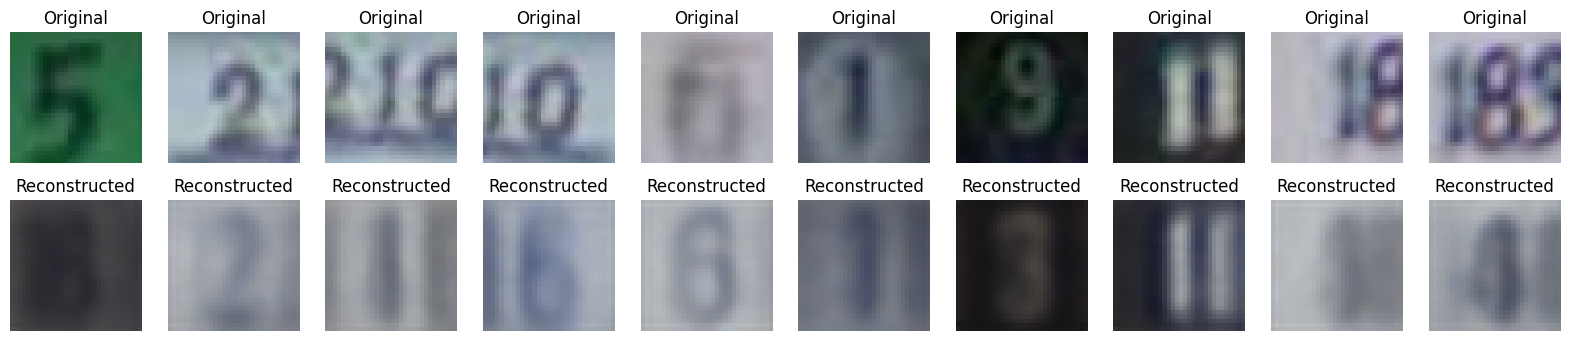

In [31]:
##Step 4: Visualize the Results
## if I change the loss function I may get better reslt but due to usage limits in Colab couldn't reconnect with my TPU, couldn't attempt change loss function.
import matplotlib.pyplot as plt  # Import matplotlib library for creating visualizations

# Define a function to visually compare original and reconstructed images.
def display_reconstruction(model, images, num_images=10):
    # Use the model to predict the reconstructed images from the input.
    pred = model.predict(images[:num_images])

    # Create a figure and a set of subplots. There are 2 rows: one for original images, one for reconstructions.
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))

    for i in range(num_images):  # Loop over the number of images to display
        # Display the original images in the first row.
        ax = axes[0, i]  # Access the subplot for the original image at position i
        ax.imshow(images[i].reshape(32, 32, 3))  # Display the image, reshaping it to its original dimensions
        ax.title.set_text("Original")  # Set the title of the subplot to "Original"
        ax.axis('off')  # Turn off the axis to make the image cleaner

        # Display the reconstructed images in the second row.
        ax = axes[1, i]  # Access the subplot for the reconstructed image at position i
        ax.imshow(pred[i].reshape(32, 32, 3))  # Display the reconstructed image, reshaping it as necessary
        ax.title.set_text("Reconstructed")  # Set the title of the subplot to "Reconstructed"
        ax.axis('off')  # Turn off the axis to make the image cleaner

    plt.show()  # Display the figure with the original and reconstructed images

# Load the best model (with the largest latent dimension) that you have saved previously.
vae = models.load_model('vae_model_dim_10.h5')

# Use the display function to show how well the model reconstructs images from the test set.
display_reconstruction(vae, x_test)  # x_test are the input images that the model will attempt to reconstruct


# Discussion:

Clarity:


The reconstructed images seem a bit blurry. The model’s ability to reduce the loss over time suggests that it was getting better at reconstructing images. However, the end loss values are still relatively high that is why the reconstructed images appear blurry.If I change the loss function I may get better reslt but due to usage limits in Colab couldn't reconnect with my TPU, couldn't attempt change loss function.


Distortion:


Although the loss was reducing, the still significant gap between training and validation losses by the 50th epoch (about 20 units difference) hints that the model might be distorting finer details or specific characteristics of some digits.

Variability:


The relatively slower reduction in validation loss compared to training loss suggests the model might not be handling the dataset's variability consistently.

Generalization:

While the validation loss improved noticeably, it remained markedly higher than the training loss throughout the training process. It's clear that my model has started to understand the training data; however, it hasn't fully grasped the underlying distribution effectively enough to generalize well to unseen data.

